<a href="https://colab.research.google.com/github/Heoyuna0819/machine_learning/blob/main/UCI_CNN%26LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = []
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    return np.dstack(loaded)

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix='/content/drive/MyDrive/UCI HAR Dataset/'):
    trainX, trainy = load_dataset_group('train', prefix)
    testX, testy = load_dataset_group('test', prefix)
    trainy = trainy - 1
    testy = testy - 1
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-1558901940.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1558901940.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1558901940.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1558901940.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(trainX, trainy, test_size=0.2, random_state=100)
y_train_one_hot = to_categorical(y_train)
y_val_one_hot   = to_categorical(y_val)

In [3]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]


In [4]:
from sklearn.preprocessing import StandardScaler

X_train_r = X_train.reshape(-1, n_features)
X_val_r = X_val.reshape(-1, n_features)
testX_r = testX.reshape(-1, n_features)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_r)
X_val_s = scaler.transform(X_val_r)
testX_s = scaler.transform(testX_r)

X_train = X_train_s.reshape(-1, n_timesteps, n_features)
X_val = X_val_s.reshape(-1, n_timesteps, n_features)
testX = testX_s.reshape(-1, n_timesteps, n_features)

In [5]:
# ===========================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, LSTM, Bidirectional,
                                     Dense, Dropout, BatchNormalization, LayerNormalization)
from tensorflow.keras.optimizers import AdamW

model = Sequential([
    # --- CNN Feature Extractor ---
    Conv1D(128, kernel_size=5, activation='relu', input_shape=(n_timesteps, n_features)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Dropout(0.25),
    LayerNormalization(),

    # --- BiLSTM Temporal Learner ---
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),

    # --- Fully Connected Layers ---
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(n_outputs, activation='softmax')
])

optimizer = AdamW(learning_rate=0.0003, weight_decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 124, 128)       │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 124, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 60, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 30, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 682,374 (2.60 MB)

 Trainable params: 681,606 (2.60 MB)

 Non-trainable params: 768 (3.00 KB)

In [6]:
#콜백 설정
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import math
import tensorflow as tf

es = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

# optional cosine annealing schedule
def cosine_annealing(epoch, lr):
    return 0.0003 * (1 + math.cos(math.pi * epoch / 50)) / 2
cosine_lr = LearningRateScheduler(cosine_annealing)

# 안정화
tf.config.run_functions_eagerly(True)

In [7]:
history = model.fit(
    X_train, y_train_one_hot,
    epochs=60,
    batch_size=32,
    validation_data=(X_val, y_val_one_hot),
    callbacks=[es, lr_scheduler, cosine_lr],
    verbose=1
)


Epoch 1/60


/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


184/184 ━━━━━━━━━━━━━━━━━━━━ 57s 281ms/step - accuracy: 0.7564 - loss: 0.7527 - val_accuracy: 0.9409 - val_loss: 0.1390 - learning_rate: 3.0000e-04
Epoch 2/60
184/184 ━━━━━━━━━━━━━━━━━━━━ 58s 314ms/step - accuracy: 0.9520 - loss: 0.1391 - val_accuracy: 0.9504 - val_loss: 0.1137 - learning_rate: 2.9970e-04
Epoch 3/60
184/184 ━━━━━━━━━━━━━━━━━━━━ 51s 280ms/step - accuracy: 0.9492 - loss: 0.1331 - val_accuracy: 0.9517 - val_loss: 0.1059 - learning_rate: 2.9882e-04
Epoch 4/60
184/184 ━━━━━━━━━━━━━━━━━━━━ 54s 293ms/step - accuracy: 0.9522 - loss: 0.1063 - val_accuracy: 0.9517 - val_loss: 0.1030 - learning_rate: 2.9734e-04
Epoch 5/60
184/184 ━━━━━━━━━━━━━━━━━━━━ 51s 278ms/step - accuracy: 0.9485 - loss: 0.1288 - val_accuracy: 0.9524 - val_loss: 0.1182 - learning_rate: 2.9529e-04
Epoch 6/60
184/184 ━━━━━━━━━━━━━━━━━━━━ 51s 275ms/step - accuracy: 0.9506 - loss: 0.1215 - val_accuracy: 0.9497 - val_loss: 0.1243 - learning_rate: 2.9266e-04
Epoch 7/60
184/184 ━━━━━━━━━━━━━━━━━━━━ 50s 274ms/step - 

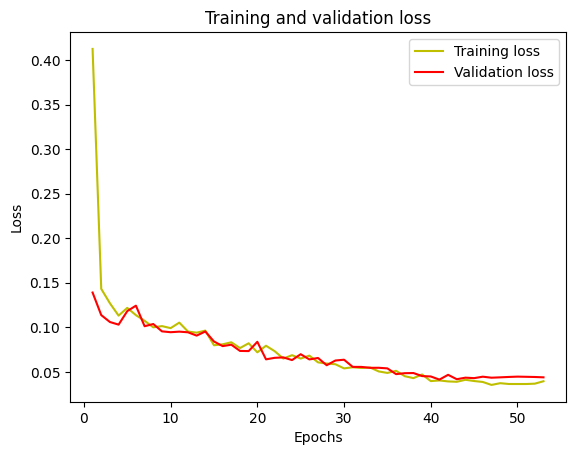

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =history.history['loss']
val_loss =history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

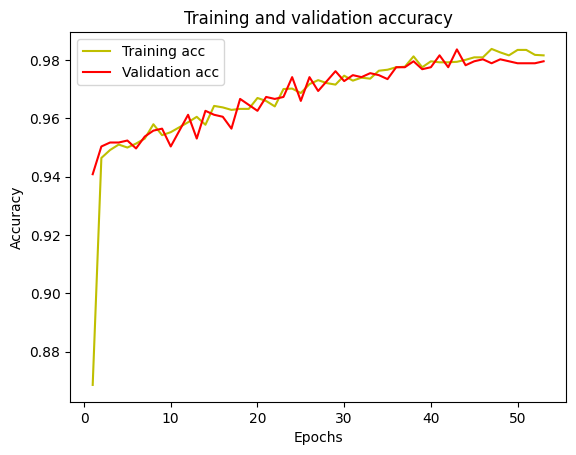

In [9]:
acc =history.history['accuracy']
val_acc =history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step
[[474   1  21   0   0   0]
 [  0 446  24   1   0   0]
 [  0  18 402   0   0   0]
 [  0   3   1 393  90   4]
 [  0   0   0  69 463   0]
 [  0   0   0   0   0 537]]
Accuracy: 0.9212758737699356

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       496
           1       0.95      0.95      0.95       471
           2       0.90      0.96      0.93       420
           3       0.85      0.80      0.82       491
           4       0.84      0.87      0.85       532
           5       0.99      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



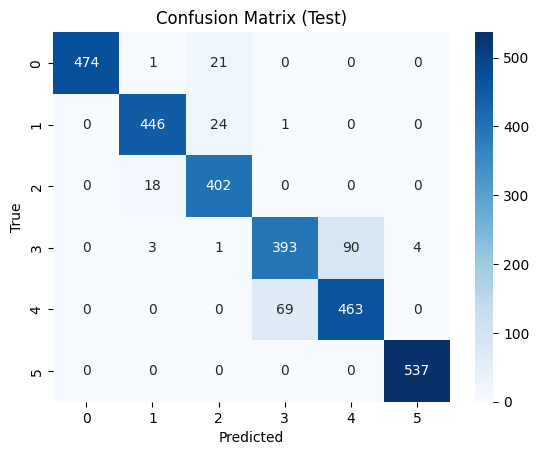

In [10]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


pred = model.predict(testX)
pred = np.argmax(pred, axis=-1)

y_true = testy.ravel()

# 혼동행렬, 정확도, 리포트
cm = confusion_matrix(y_true, pred)
print(cm)
print("Accuracy:", accuracy_score(y_true, pred))
print("\nClassification Report:")
print(classification_report(y_true, pred))

# 혼동행렬 시각화
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test)')
plt.show()
